In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
from sklearn.metrics import precision_score, f1_score, roc_auc_score, cohen_kappa_score, confusion_matrix 
from spot import *
import bisect

In [2]:
class DataProcess:
    INVALID_ITEM = -1
    def __init__(self, data_file, data_size, config):
        self.file = data_file
        self.data_size = data_size
        self.fake_eps = config['fake_eps']
        self.min_delay = config['min_delay']
        self.max_delay = config['max_delay']
        self.max_bw = np.log(config['max_bw']*1024*1024)
        self.cong_rate = config['cong_rate']
        self.stat_size = config['stat_size']
        self.avg_weight = config['avg_weight']
        self.link_delay_map = {}
        self.path_delay_map = {}
        self.link_loads_map = {}
        self.valid_delay_map = {}
        self.valid_loads_map = {}
        self.delay_limit_map = {}
        self.quality_map = {}
        self.dataset = []
        self.target_dpids = self._get_target_dpids()
    
    def preprocess(self):
        with open(self.file, 'r+') as fp:
            for _ in range(self.data_size):
                line = fp.readline()
                if not line:
                    break 
                self._get_link_delay(line)
                self._get_data_item(line)
                self._get_link_quality(line)
    
    def _get_target_dpids(self):
        target_dpids = set()
        for ep in self.fake_eps:
            dpid = ep[0]
            target_dpids.add(dpid)
        return target_dpids
    
    def _get_link_delay(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        loads = float(res_list[-1])
        path_delay = float(res_list[-2])
        cs_delay = float(res_list[-3])
        sc_delay = float(res_list[-4])
        link_delay = path_delay - (cs_delay + sc_delay)/2
        if link_delay < self.min_delay:
            link_delay = self.min_delay
        link_delays = self.link_delay_map.setdefault(link, [])
        link_delays.append(link_delay)
        link_loads = self.link_loads_map.setdefault(link, [])
        link_loads.append(loads)
        path_delays = self.path_delay_map.setdefault(link, [])
        path_delays.append(path_delay)
    
    def _get_valid_delay(self, link, delay):
        valid_list = self.valid_delay_map.setdefault(link, [self.max_delay])
        if delay == DataProcess.INVALID_ITEM:
            if len(valid_list) < self.stat_size:
                item_list = self.link_delay_map[link]
                s_loc = -min(len(item_list), self.stat_size)
                valid_delay = np.median(item_list[s_loc:])
            else:
                valid_delay = np.median(valid_list)
        else:
            if len(valid_list) >= self.stat_size:
                valid_list.pop(0)
            valid_list.append(delay)
            if len(valid_list) < len(self.avg_weight):
                valid_delay = sum(valid_list)/len(valid_list)
            else:
                s_loc = -len(self.avg_weight)
                valid_delay = sum([self.avg_weight[i]*d \
                    for i, d in enumerate(valid_list[s_loc:])])
        return valid_delay
        
    def _get_valid_loads(self, link, loads):
        valid_list = self.valid_loads_map.setdefault(link, [0])
        if loads == DataProcess.INVALID_ITEM:
            valid_loads = 0
        else:
            if len(valid_list) >= self.stat_size:
                valid_list.pop(0)
            valid_list.append(loads)
            if len(valid_list) < len(self.avg_weight):
                valid_loads = sum(valid_list)/len(valid_list)
            else:
                s_loc = -len(self.avg_weight)
                valid_loads = sum([self.avg_weight[i]*d \
                    for i, d in enumerate(valid_list[s_loc:])])
        return valid_loads
        
    def _get_link_quality(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        delay = float(res_list[-2])
        loads = float(res_list[-1])
        
        # The key idea of this tricks locates at that, the delay beyond a so called 'max_delay' should
        # make no sense to indicate the link quality, as well as the reliability of the links.
        # Statistic of the median delay of the links of the target dpid, so as to obtain the valid delay
        # which is used to indicated the reliability of the links.
        
        if delay > self.max_delay:
            delay = self._get_valid_delay(link, DataProcess.INVALID_ITEM)
            loads = self._get_valid_loads(link, DataProcess.INVALID_ITEM)
        else:
            delay = self._get_valid_delay(link, delay)
            loads = self._get_valid_loads(link, loads)
            
        tq = 1 - np.tanh(delay/self.max_delay)
        lq = 1 / (1 + np.exp(-(loads-self.max_bw*self.cong_rate)))
        
        # The degree of indicating link quality mainly depends on the delay quality, e.g., 
        # Link A: high loads, low delay
        # Link B: low loads, low delay
        # Link C: high loads, high delay
        # Link D: low loads, high delay 
        # we hat A > B > C > D
        # Eq. Q = (Qt + np.exp(Qt-max_Qt) * Ql) / 2, where max_Qt = 1-np.tanh(0) = 1
        quality = tq * (1 + np.exp(tq - 1) * lq) / 2 
        quality_list = self.quality_map.setdefault(link, [])
        quality_list.append(quality)
    
    def _get_data_item(self, line):
        res_list = line.split()
        link = ''.join(res_list[:3])
        dpid = link.split(':')[0]
        if not dpid in self.target_dpids:
            return 
        path_delay = float(res_list[-2])
        cs_delay = float(res_list[-3])
        sc_delay = float(res_list[-4])
        delay = path_delay - (cs_delay + sc_delay)/2
        if delay < self.min_delay:
            delay = self.min_delay
        if any([x in link for x in self.fake_eps]):
            is_forged_link = True 
        else:
            is_forged_link = False 
        data_item = [cs_delay, sc_delay, delay, is_forged_link]
        self.dataset.append(data_item)
    
    def query_quality_map(self):
        return self.quality_map 
    
    def query_delay_map(self):
        return self.link_delay_map
    
    def query_delay_map2(self):
        return self.path_delay_map
    
    def query_dataset(self):
        return np.array(self.dataset)

In [3]:
sns.set_theme(style='ticks', font='Times New Roman', font_scale=1.3)

In [4]:
# config dataset parameters and running parameters 

# data_size: the number of data items
# fake_eps: the endpoints of the fabricated links.
# min_delay: tx delay, set to 0.5ms in Mininet.
# max_delay: tx delay, set to 5ms empirically, a delay larger than max_delay should no longer 
#   indicate the link quality effectively.
# max_bw: maximum bandwidth, set to 100Mb/s in Mininet.
# cong_rate: congestion ratio, 80%.
# stat_size: do the statistic each 100 items.
# avg_weight: moving average of the latest 4 items.

ds_config = {
    'fake_eps': ['2:1', '4:1'],
    'min_delay': 0.5,
    'max_delay': 5,
    'max_bw': 100,
    'cong_rate': 0.8,
    'stat_size': 100,
    'avg_weight': [0.1, 0.2, 0.3, 0.4],
}

data_files = [
    r'../dataset/5switches/sock_link_0.5_no_load_no_attack.txt',
    r'../dataset/5switches/switch_link_0.5_no_load_no_attack.txt',
]

data_size = 2000

normal_link_1 = '2:2->1:2'
fabricated_link_1 = '2:1->4:1'

normal_link_2 = '2:2->1:2'
fabricated_link_2 = '2:3->4:2'

processors = [DataProcess(data_file, data_size, ds_config) for data_file in data_files]

for processor in processors:
    processor.preprocess()

delays = [processor.query_delay_map() for processor in processors]
qualities = [processor.query_quality_map() for processor in processors] 

ib_delay = pd.DataFrame({
    'normal_link': delays[0][normal_link_1],
    'fabricated_link': delays[0][fabricated_link_1]
})

ib_linkq = pd.DataFrame({
    'normal_link': qualities[0][normal_link_1],
    'fabricated_link': qualities[0][fabricated_link_1]
})

s_delay = pd.DataFrame({
    'normal_link': delays[1][normal_link_2],
    'fabricated_link': delays[1][fabricated_link_2]
})

s_linkq = pd.DataFrame({
    'normal_link': qualities[1][normal_link_2],
    'fabricated_link': qualities[1][fabricated_link_2]
})

print('normal link mean: {:.3f}, std: {:.3f}\nfabricated link mean: {:.3f}, std: {:.3f}'.format(
    np.mean(delays[1][normal_link_2]), np.std(delays[1][normal_link_2]),
    np.mean(delays[1][fabricated_link_2]), np.std(delays[1][fabricated_link_2])
))


normal link mean: 1.219, std: 0.437
fabricated link mean: 1.883, std: 0.500


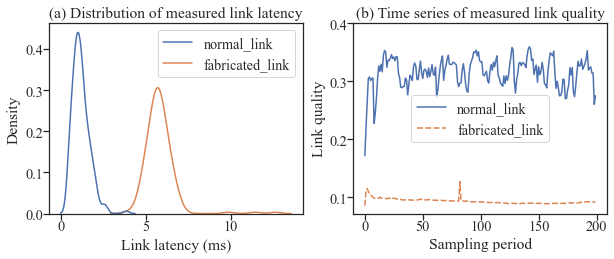

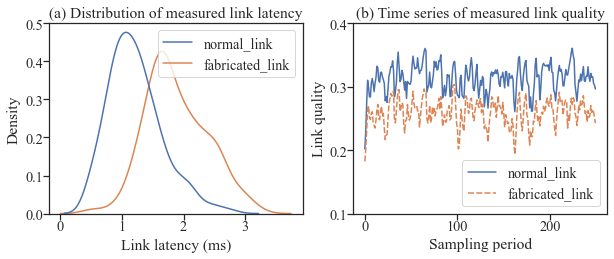

In [5]:
def show_delay_quality(delay, linkq, method):
    f, axes = plt.subplots(1, 2, figsize=(10, 3.5))
    sns.kdeplot(data=delay, ax=axes[0])
    sns.lineplot(data=linkq, ax=axes[1])
    axes[0].set_title('(a) Distribution of measured link latency')
    axes[0].set_xlabel('Link latency (ms)')
    axes[1].set_title('(b) Time series of measured link quality')
    axes[1].set_xlabel('Sampling period')
    axes[1].set_ylabel('Link quality')
    axes[1].set_yticks([0.1, 0.2, 0.3, 0.4])
    for i in range(2):
        axes[i].tick_params(pad=0)
    f.savefig('{}.png'.format(method), format='png', bbox_inches='tight', dpi=300)

show_delay_quality(ib_delay, ib_linkq, 'IB-LFA')
show_delay_quality(s_delay, s_linkq, 'S-LFA')

In [6]:
class MultiPathSimulator:
    def __init__(self, quality_map, gamma):
        self.quality_map = quality_map
        self.gamma = gamma

    def simulator(self, corr_links, simu_range):
        factors = {link:1 for link in corr_links}
        records = []
        for i in simu_range:
            max_quality = 0 
            for link in corr_links:
                q = self.quality_map[link][i] * factors[link]
                if q >= max_quality:
                    max_quality = q
                    best_link = link 
            records.append(corr_links.index(best_link))
            # update discount factor
            for link in corr_links:
                if link == best_link:
                    factors[link] *= self.gamma
                else:
                    factors[link] = 1
        return records
    
    def calc_period_list(self, records):
        idx = 0
        period_list = [idx]
        while idx < len(records):
            curr_rec = records[idx]
            while idx < len(records) and curr_rec == records[idx]:
                idx += 1
            if idx < len(records):
                curr_rec = records[idx]
                while idx < len(records) and curr_rec == records[idx]:
                    idx += 1
            period_list.append(idx)
        return period_list
            
    def calc_k_map(self, corr_links, records):
        k_map = {link: [] for link in corr_links}
        curr_rec = records[0]
        counter = 0
        for rec in records:
            if rec == curr_rec:
                counter += 1
            else:
                curr_link = corr_links[curr_rec]
                k_map[curr_link].append(counter)
                curr_rec = rec
                counter = 1
        return k_map            

    def calc_entropy_list(self, records, interval):
        period_list = self.calc_period_list(records)
        period_length = len(period_list)
        entropy_list = []
        num_1st = 0
        idx = 0
        for idx in range(0, period_length-interval-1):
            start = period_list[idx]
            end_idx = min(idx+interval, period_length-1)
            end = period_list[end_idx]
            seqs = np.array(records[start:end])
            num_1st = np.sum(seqs == 1)
            prob = num_1st / len(seqs)
            entropy = -prob * np.log2(prob) - (1-prob) * np.log2(1-prob)
            entropy_list.append(entropy)
        return entropy_list
    
    # discrete
    def get_k_dist(self, k_map, link):
        assert(link in k_map)
        k_values = k_map[link]
        k_set = set(k_values)
        k_prob = [k_values.count(k)/len(k_values) for k in k_set]
        return list(k_set), k_prob

In [7]:

class CorrLinksVerification:
    def __init__(self, quality_map, train_corr_links, test_corr_links, is_fake, run_config):
        self.quality_map = quality_map
        self.train_corr_links = train_corr_links
        self.test_corr_links = test_corr_links
        self.is_fake = is_fake
        self.interval = run_config['interval']  
        self.q_e = run_config['q_e']
        self.q_k = run_config['q_k']
        self.depth_e = run_config['depth_e']
        self.depth_k = run_config['depth_k']
        self.simu = MultiPathSimulator(quality_map, run_config['gamma'])
    
    def get_refer_link(self):
        train_link_set = set(self.train_corr_links)
        test_link_set = set(self.test_corr_links)
        refer_link = train_link_set & test_link_set
        return refer_link.pop()
                        
    def calc_e_thr(self, train_list_init, train_list_supl):
        rev_list_init = [-x for x in train_list_init]
        rev_list_supl = [-x for x in train_list_supl]
        s = dSPOT(self.q_e, depth=self.depth_e)
        s.fit(rev_list_init, rev_list_supl)
        s.initialize(verbose=True)
        thr = s.run()
        e_thr_list = [-x for x in thr['thresholds']]
        return e_thr_list
    
    def _calc_k_thr_base(self, k_list):
        k_set = set(k_list)
        probs = [k_list.count(k)/len(k_list) for k in k_set]
        k_exp = sum([probs[i]*k for i,k in enumerate(k_set)])
        p_hat = 1 / k_exp
        cum_dist = p_hat
        idx = 0
        while cum_dist < 1 - self.q_k:
            cum_dist += (p_hat * ((1-p_hat) ** (idx-1)))
            idx += 1
        k_thr = max(idx, max(k_set)) + 1
        return k_thr
    
    def calc_k_thr(self, k_list_init, k_list_supl):
        k_thr_list = []
        k_list = k_list_init[:self.depth_k]
        k_thr0 = self._calc_k_thr_base(k_list_init)
        for item in k_list_supl:
            k_list.pop(0)
            k_list.append(item)
            k_thr = self._calc_k_thr_base(k_list)
            k_thr = max(k_thr, k_thr0)
            k_thr_list.append(k_thr)
        return k_thr_list
    
    def train(self, train_range, test_range):
        train_records_init = self.simu.simulator(self.train_corr_links, train_range)
        train_records_supl = self.simu.simulator(self.train_corr_links, test_range)
        
        train_e_list_init = self.simu.calc_entropy_list(train_records_init, self.interval)
        train_e_list_supl = self.simu.calc_entropy_list(train_records_supl, self.interval)
        e_thr_list = self.calc_e_thr(train_e_list_init, train_e_list_supl)
        
        train_k_map_init = self.simu.calc_k_map(self.train_corr_links, train_records_init)
        train_k_map_supl = self.simu.calc_k_map(self.train_corr_links, train_records_supl)
        refer_link = self.get_refer_link()
        train_k_list_init = train_k_map_init[refer_link]
        train_k_list_supl = train_k_map_supl[refer_link]
        k_thr_list = self.calc_k_thr(train_k_list_init, train_k_list_supl)
        
        test_records = self.simu.simulator(self.test_corr_links, test_range)
        test_e_list = self.simu.calc_entropy_list(test_records, self.interval)
        test_k_map = self.simu.calc_k_map(self.test_corr_links, test_records)
        refer_link = self.get_refer_link()
        test_k_list = test_k_map[refer_link]
        
        return test_records, train_records_supl, \
            e_thr_list, k_thr_list, test_e_list, test_k_list
        
    
    def pred(self, test_records, supl_records, e_thr_list, k_thr_list, test_e_list, test_k_list):
        y_pred = [0] * len(test_records)
        supl_period_list = self.simu.calc_period_list(supl_records)
        test_period_list = self.simu.calc_period_list(test_records)
        
        for i, curr_e in enumerate(test_e_list):
            supl_loc = bisect.bisect(supl_period_list, test_period_list[i])
            if supl_loc == 0:
                e_thr = e_thr_list[0]
            elif supl_loc >= len(e_thr_list)-1:
                e_thr = e_thr_list[-1]
            else:
                s_loc = max(0, supl_loc-self.interval+1)
                e_loc = min(supl_loc+self.interval, len(e_thr_list)-1)
                e_thr = min(e_thr_list[s_loc:e_loc])
            s_idx = test_period_list[i]
            e_idx = test_period_list[i+self.interval-1]
            if curr_e <= e_thr:
                if not self.is_fake:
                    print('[+] FP: curr_e: {} e_thr: {}'.format(curr_e, e_thr))
                for j in range(s_idx, e_idx):
                    y_pred[j] = 1
        # print('test_e_list {}: {}\n e_thr_list {}: {}\n'.format(
        #    len(test_e_list), test_e_list, len(e_thr_list), e_thr_list))
        for i, curr_k in enumerate(test_k_list):
            supl_loc = bisect.bisect(supl_period_list, test_period_list[i])
            if supl_loc == 0:
                k_thr = k_thr_list[0]
            elif supl_loc >= len(k_thr_list)-1:
                k_thr = k_thr_list[-1]
            else:
                k_thr = k_thr_list[supl_loc-1]
            s_idx = test_period_list[i]
            e_idx = test_period_list[i+1]
            if curr_k > k_thr:
                if not self.is_fake:
                    print('[+] FP: curr_k: {} k_thr: {}'.format(curr_k, k_thr))
                for j in range(s_idx, e_idx):
                    y_pred[j] = 1
        # print('test_k_list {}: {}\n k_thr_list {}: {}\n'.format(
        #    len(test_k_list), test_k_list, len(k_thr_list), k_thr_list))
        return y_pred
                
    def fit(self, train_range, test_range):
        test_records, supl_records, e_thr_list, k_thr_list, \
            test_e_list, test_k_list = self.train(train_range, test_range)
        y_pred = self.pred(test_records, supl_records, \
            e_thr_list, k_thr_list, test_e_list, test_k_list)
        y_true = [self.is_fake] * len(test_records)
        
        return y_pred, y_true


In [8]:
def show_model_metrics(model_name, y_true, y_pred):   
    cnf_matrix = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cnf_matrix.ravel()
    
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    
    Pr = precision_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    AUC = roc_auc_score(y_true, y_pred)
    print(f'''
          name : {model_name},
          TPR: {TPR},
          FPR: {FPR},
          Precision: {Pr},
          f1_score: {F1},
          auc_score: {AUC}
          ''')
    return TPR, FPR, Pr, F1, AUC 

In [26]:
num_switch = 5

run_config = {
    'q_e': 1e-5,
    'q_k': 1e-5,
    'depth_e': 3,
    'depth_k': 100,
    'gamma': 0.9,
    'interval':10,
}

data_file = r'../dataset/{}switches/switch_link_0.5_no_load_no_attack.txt'.format(num_switch) # added for reviewer 
data_size = 14*3000
processor = DataProcess(data_file, data_size, ds_config) 
processor.preprocess()

# Notice: both normal_link_1_2 and normal_link_1_3 are NOT  Correlated-links with normal_link_1_1, 
# because switch-relaying LFA lacks of Correlated-links in this topology. Besides, the switch 3 
# is nearly dead because the measurement results of links (3:3 -> 4:2 and 3:2 -> 2:3) do not change.  
# However, the measured data for train_corr_links and test_corr_links is somewhat correlated (According to the output of link quality). 
# We have to use them for evaluation. Notice that, this is the most worse link combination.
normal_link_1 = '5:2->4:3' # The link mark is sorted by the first item of link quality list
normal_link_2 = '2:2->1:2'
normal_link_3 = '1:2->2:2'
normal_link_4 = '4:3->5:2' 
fabricated_link_1 = '2:3->4:2'  
fabricated_link_2 = '4:2->2:3'

# Both normal and fabricated link 1 start with switch 2,
# thus we use normal_link_2 '2:2->1:2' for training.
train_corr_links_1 = [normal_link_2, normal_link_3] 
# test_corr_links_1_1 = [normal_link_2, normal_link_4] 
# Can also be 
test_corr_links_1_1 = [normal_link_2, normal_link_1] 
test_corr_links_1_2 = [normal_link_2, fabricated_link_1]
# Both normal and fabricated link 2 start with switch 4,
# thus we use normal_link_4 '4:3->5:2' for training.
train_corr_links_2 = [normal_link_4, normal_link_2] 
# test_corr_links_2_1 = [normal_link_4, normal_link_3] 
# Can also be
test_corr_links_2_1 = [normal_link_4, normal_link_1] 
test_corr_links_2_2 = [normal_link_4, fabricated_link_2]


quality_map = processor.query_quality_map()

for k, v in quality_map.items():
    quality_map[k] = np.array(v)
    print(k, quality_map[k])
    
train_range = range(0, 2000)
test_range = range(2000, 3000)

clv_1_0 = CorrLinksVerification(quality_map, train_corr_links_1, test_corr_links_1_1, 0, run_config)
y_pred_1_0, y_true_1_0=clv_1_0.fit(train_range, test_range)

clv_1_1 = CorrLinksVerification(quality_map, train_corr_links_1, test_corr_links_1_2, 1, run_config)
y_pred_1_1, y_true_1_1=clv_1_1.fit(train_range, test_range)

clv_2_0 = CorrLinksVerification(quality_map, train_corr_links_2, test_corr_links_2_1, 0, run_config)
y_pred_2_0, y_true_2_0=clv_2_0.fit(train_range, test_range) 

clv_2_1 = CorrLinksVerification(quality_map, train_corr_links_2, test_corr_links_2_2, 1, run_config)
y_pred_2_1, y_true_2_1=clv_2_1.fit(train_range, test_range)

y_pred = y_pred_1_0 + y_pred_1_1 + y_pred_2_0 + y_pred_2_1
y_true = y_true_1_0 + y_true_1_1 + y_true_2_0 + y_true_2_1

TPR, FPR, Pr, F1, AUC = show_model_metrics('clv', y_true, y_pred)

4:3->5:2 [0.18482445 0.23076561 0.25388843 ... 0.35977186 0.36087797 0.35398737]
5:2->4:3 [0.22028672 0.22443722 0.2923544  ... 0.3655032  0.3289002  0.30086905]
1:2->2:2 [0.19718263 0.22982023 0.28082392 ... 0.37670519 0.35070177 0.26816203]
2:2->1:2 [0.20197492 0.23076569 0.27544336 ... 0.35015465 0.3443516  0.2975142 ]
2:3->4:2 [0.18212786 0.20208283 0.23098074 ... 0.2945133  0.27012913 0.22111626]
4:2->2:3 [0.16137981 0.18704495 0.21095453 ... 0.31355242 0.30892178 0.24698285]
3:3->4:2 [0.20036799 0.23529396 0.29087089 ... 0.31692848 0.31692797 0.31692851]
3:2->2:3 [0.22097463 0.26633035 0.33895658 ... 0.37287404 0.37287337 0.37287408]
Initial threshold : 0.012110118293760297
Number of peaks : 17
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.1428073298535648
	σ = 0.0037208791308623802
	L = 80.52224493049815
Extreme quantile (probability = 1e-05): 0.029333163495403516


100%|██████████| 446/446 [00:00<00:00, 8934.66it/s]


[+] FP: curr_e: 0.9509560484549725 e_thr: 0.9566119293495111
[+] FP: curr_e: 0.9509560484549725 e_thr: 0.9566119293495111
[+] FP: curr_e: 0.9509560484549725 e_thr: 0.9566119293495111
[+] FP: curr_e: 0.9509560484549725 e_thr: 0.9513960945197439
Initial threshold : 0.012110118293760297
Number of peaks : 17
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.1428073298535648
	σ = 0.0037208791308623802
	L = 80.52224493049815
Extreme quantile (probability = 1e-05): 0.029333163495403516


100%|██████████| 446/446 [00:00<00:00, 8955.88it/s]


Initial threshold : 0.01230749110419671
Number of peaks : 17
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.13089778410496455
	σ = 0.0038464375928603137
	L = 79.75559594286581
Extreme quantile (probability = 1e-05): 0.030768405469913065


100%|██████████| 438/438 [00:00<00:00, 4754.68it/s]


[+] FP: curr_e: 0.9612366047228759 e_thr: 0.9624635726220181
Initial threshold : 0.01230749110419671
Number of peaks : 17
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.13089778410496455
	σ = 0.0038464375928603137
	L = 79.75559594286581
Extreme quantile (probability = 1e-05): 0.030768405469913065


100%|██████████| 438/438 [00:00<00:00, 5314.25it/s]


          name : clv,
          TPR: 0.995,
          FPR: 0.038,
          Precision: 0.9632139399806389,
          f1_score: 0.9788489916379733,
          auc_score: 0.9784999999999999
          
